In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from gensim.models import Word2Vec

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# import data

data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')

In [3]:
# shorten column names

data.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)

In [4]:
# drop this column since this model will only predict sentiment, not the product as well

data.drop(columns = 'emotion_in_tweet_is_directed_at', inplace=True)

In [5]:
# check out label distribution

data['label'].value_counts(normalize=True)

No emotion toward brand or product   0.59265
Positive emotion                     0.32750
Negative emotion                     0.06269
I can't tell                         0.01716
Name: label, dtype: float64

In [5]:
# combine "No emotion toward brand or product" and "I can't tell"
# shorten combined label name to "No emotion"

data['label'] = data['label'].map(lambda x: 'Not negative' if x != "Negative emotion"
                                 else x)

In [6]:
# check out new label distribution

data['label'].value_counts(normalize=True)

Not negative       0.93731
Negative emotion   0.06269
Name: label, dtype: float64

In [8]:
# create stopwords list

stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
stopwords_list += ['sxsw','mention','rt']

In [9]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
# create X and y

X = data['text']
y = data['label']

In [11]:
# reformat X to lowercase and string (some tweets were numeric)

X = X.astype(str).map(lambda x: x.lower())

In [12]:
# create holdout set

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.05)

print(len(X_train), len(X_holdout))

8638 455


In [13]:
# create count vectorizer for testing

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)

In [14]:
# create Multinomial Naive Bayes model for testing

nb_count = MultinomialNB()
nb_count.fit(X_train_cv, y_train)
y_train_count_nb_pred = nb_count.predict(X_train_cv)

In [16]:
print(cross_val_score(nb_count, X_train_cv, y=y_train, cv=5).mean())

0.9223197339638423


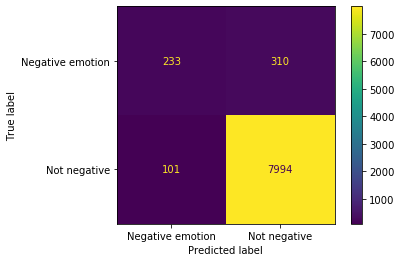

In [18]:
plot_confusion_matrix(nb_count, X_train_cv, y_train)

In [19]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

In [20]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_train_tfidf_pred = nb_tfidf.predict(X_train_tfidf)

In [33]:
print(cross_val_score(nb_tfidf, X_train_tfidf, y=y_train, cv=5).mean())

0.9372540425486285


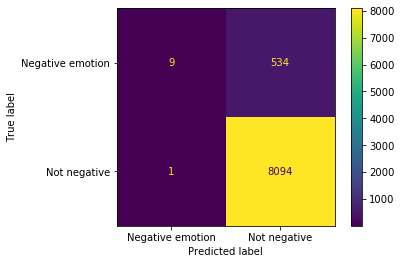

In [34]:
plot_confusion_matrix(nb_tfidf, X_train_tfidf, y_train)

In [35]:
cv_stop = CountVectorizer(stop_words=stopwords_list)
X_train_cv_stop = cv_stop.fit_transform(X_train)

In [36]:
nb_cv_stop = MultinomialNB()
nb_cv_stop.fit(X_train_cv_stop, y_train)
y_train_cv_stop_pred = nb_cv_stop.predict(X_train_cv_stop)

In [37]:
print(cross_val_score(nb_cv_stop, X_train_cv_stop, y=y_train, cv=5).mean())

0.9132902137082073


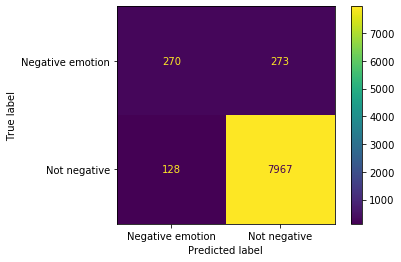

In [39]:
plot_confusion_matrix(nb_cv_stop, X_train_cv_stop, y_train)

In [40]:
tfidf_stop = TfidfVectorizer(stop_words=stopwords_list)
X_train_tfidf_stop = tfidf_stop.fit_transform(X_train)

In [41]:
nb_tfidf_stop = MultinomialNB()
nb_tfidf_stop.fit(X_train_tfidf_stop, y_train)
y_train_tfidf_stop_pred = nb_tfidf_stop.predict(X_train_tfidf_stop)

In [42]:
print(cross_val_score(nb_tfidf_stop, X_train_tfidf_stop, y=y_train, cv=5).mean())

0.9376014658259881


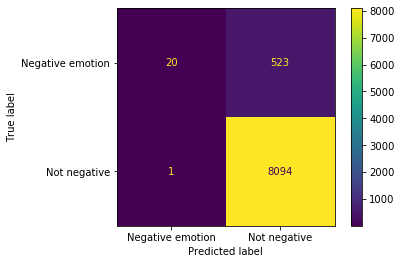

In [43]:
plot_confusion_matrix(nb_tfidf_stop, X_train_tfidf_stop, y_train)

In [44]:
X_train_tokens = X_train.map(lambda x: word_tokenize(x))

In [45]:
total_vocabulary = set(word for tweet in X_train_tokens for word in tweet)

In [46]:
len(total_vocabulary)

10567

In [47]:
# from Codealong

glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [50]:
glove['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [51]:
# from Codealong

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [52]:
def NLP_model_tester(X, y, vectorizers, models, cv=5):
    
    scores = []
    
    for v in vectorizers:
        for m in models:
            pipe = Pipeline([v, m])
            scores.append((v[0], m[0], cross_val_score(pipe, X, y, cv=cv).mean()))
            plot_confusion_matrix()
    return scores

In [70]:
vec_list = [ #('Word2Vec Vectorizer', W2vVectorizer(glove)),
           ('CountVectorizer', CountVectorizer()),
           ('TfidfVectorizer', TfidfVectorizer())]
mod_list = [('Random Forest', RandomForestClassifier()),
           ('Support Vector Machine', SVC()),
           ('Logistic Regression', LogisticRegression())]

In [67]:
NLP_model_tester(X_train, y_train, vec_list, mod_list, cv=2)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[('Word2Vec Vectorizer', 'Random Forest', 0.9373697615188701),
 ('Word2Vec Vectorizer', 'Support Vector Machine', 0.937138226441306),
 ('Word2Vec Vectorizer', 'Logistic Regression', 0.937138226441306),
 ('CountVectorizer', 'Random Forest', 0.9431581384579764),
 ('CountVectorizer', 'Support Vector Machine', 0.9395693447557305),
 ('CountVectorizer', 'Logistic Regression', 0.9376012965964343),
 ('TfidfVectorizer', 'Random Forest', 0.9428108358416301),
 ('TfidfVectorizer', 'Support Vector Machine', 0.9403797175272053),
 ('TfidfVectorizer', 'Logistic Regression', 0.937253993980088)]

In [71]:
def confusion_matrix_generator(X, y, vectorizers, models):
    for v in vectorizers:
        for m in models:
            vectorizer = v[1]
            X_vec = v[1].fit_transform(X)
            model = m[1]
            model.fit(X_vec, y)
            plot_confusion_matrix(model, X_vec, y)
            

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


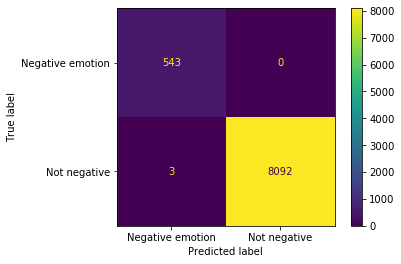

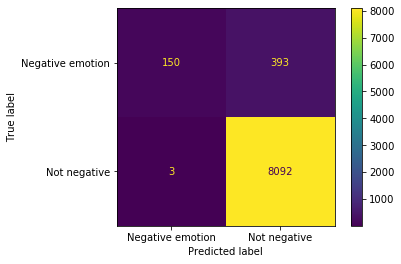

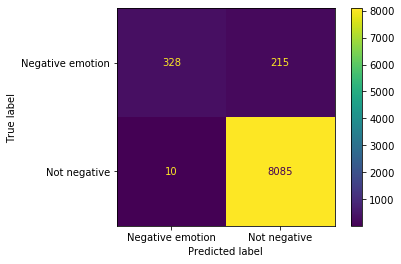

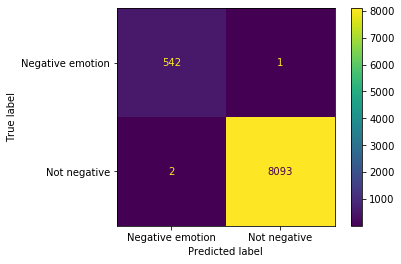

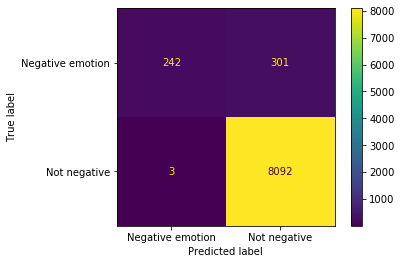

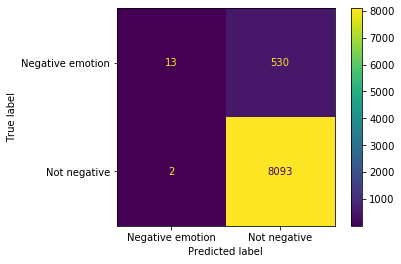

In [72]:
confusion_matrix_generator(X_train, y_train, vec_list, mod_list)

In [55]:
one_hot_y = pd.get_dummies(y_train).values

In [61]:
tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
list_tokenized_tweets = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=100)

In [62]:
nn = Sequential()
embedding_size = 128
nn.add(Embedding(5000, embedding_size))
nn.add(LSTM(25, return_sequences=True))
nn.add(GlobalMaxPool1D())
nn.add(Dropout(0.5))
nn.add(Dense(50, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(2, activation='softmax'))

nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [63]:
nn.fit(X_t, one_hot_y, epochs=5, validation_split=0.1)

Epoch 1/5
243/243 [==============================] - 8s 27ms/step - loss: 0.3546 - accuracy: 0.9303 - val_loss: 0.2019 - val_accuracy: 0.9375
Epoch 2/5
243/243 [==============================] - 7s 27ms/step - loss: 0.2029 - accuracy: 0.9323 - val_loss: 0.1855 - val_accuracy: 0.9375
Epoch 3/5
243/243 [==============================] - 7s 27ms/step - loss: 0.1391 - accuracy: 0.9369 - val_loss: 0.2562 - val_accuracy: 0.9375
Epoch 4/5
243/243 [==============================] - 7s 28ms/step - loss: 0.0936 - accuracy: 0.9572 - val_loss: 0.2699 - val_accuracy: 0.9248
Epoch 5/5
243/243 [==============================] - 7s 28ms/step - loss: 0.0765 - accuracy: 0.9722 - val_loss: 0.3199 - val_accuracy: 0.9317
